In [31]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# for display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  #default 'last_expr'

# <a id='0'>Group Operation and Data Aggregation
----Extract descriptive statistics from data

## Highlights
- <a href='#titanic'>Bucket Analysis Example: Survival Rate on Titanic for each Age Group
- <a href='#31'> Filling Missing Values with Group-Specific Values </a>

## Contents
Group a dataset using key values, then use an aggregate function to obtain group statistics, or use an apply function for an element-wise tranformation. <br>

- <a href='#1'> GroupBy Mechanics
- <a href='#2'> GroupBy and Aggregate
- <a href='#3'> GroupBy and Apply
    - <a href='#31'> Example: Filling Missing Values with Group-Specific Values
    - <a href='#33'> Example: Weighted Average by Group, and Yearly Correlation b/t Stock Prices
- <a href='#4'> Cross-Tabulation and Pivot Tables

## <a id='m'>MultiIndex and Index Slicing
Multi-indexing is a powerful functionality of Pandas. You can use it to group information freely and output any part of the DataFrame freely. Let's demo it with the widely used Tips data set.

In [51]:
tips = pd.read_csv('examples/tips.csv')
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.head(3)

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.05945
1,10.34,1.66,No,Sun,Dinner,3,0.16054
2,21.01,3.50,No,Sun,Dinner,3,0.16659


### Task
Extract the 'total_bill' of all dinner party with size 4 on Sunday, and they should be non-smokers too! Yes, it's purposefully mouthful, just to showcase what we can do with multi-indexing.

Get ready: generate multi-index

In [52]:
tips_multi = tips.set_index(['time', 'day', 'size', 'smoker']).sort_index()
tips_multi.head()

total_bill   tip  tip_pct
time   day size smoker                           
Dinner Fri 2    No           22.49  3.50  0.15562
                No           22.75  3.25  0.14286
                No           12.46  1.50  0.12039
                Yes          28.97  3.00  0.10356
                Yes           5.75  1.00  0.17391

Access:

In [53]:
tips_multi.loc[pd.IndexSlice['Dinner','Sun', 4,'No'], ['total_bill']].head()

total_bill
time   day size smoker            
Dinner Sun 4    No           24.59
                No           25.29
                No           26.88
                No           35.26
                No           18.43

Mission accomplished!

## <a id='1'> GroupBy Mechanics

Generate a list of values matching the length of the target column for grouping. There are multiple ways to do this generation. <br>
- Internal columns of the DF (**most common**)
- External arrays
- Dict or Series
- Functions


In [32]:
df = pd.DataFrame({'Key1' : ['a', 'a', 'b', 'b', 'a'],
                   'Key2' : ['one', 'two', 'one', 'two', 'one'],
                   'Data1' : np.random.randn(5),
                   'Data2' : np.random.randn(5)})
df

,Key1,Key2,Data1,Data2
0,a,one,0.90003,-0.37795
1,a,two,2.54465,-1.37206
2,b,one,-1.15715,0.23158
3,b,two,0.77962,1.59466
4,a,one,0.53223,-1.17246


### Grouping with internal column(s)

In [8]:
# group df using key1
df.groupby('Key1').mean()     # return a df, automatically excluding categorical col 'key2'

# group by key1, count the occurencies
df.groupby(['Key1']).size()   # return se

,Data1,Data2
Key1,,
a,-0.134474,0.308532
b,0.389573,0.231900


Key1
a    3
b    2
dtype: int64

### Grouping with External Arrays

In [121]:
# group using 
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years  = np.array([2005,           2005,         2006,   2005,  2006])
df.groupby([states, years]).mean()

Data1    Data2
California 2005  0.41685 -0.87681
           2006 -1.12123  1.10541
Ohio       2005  0.33193 -0.04941
           2006  0.31011  0.60106

### Accessing Groups

Groupby object behaves like a Python generator. You can easily turn it into a list of tuples to access it. You can also accessed it through its methods.

In [12]:
grb = df.groupby('Key1')
type(grb)
type(list(grb))    # grb to a list of tuples
type(list(grb)[0]) # list(grb): [(k1, sub_df1), (k2, sub_df2), ...]

pandas.core.groupby.groupby.DataFrameGroupBy

list

tuple

Loop through Groupby object

In [7]:
for key, sub_df in grb:
    print(key)
    print(sub_df)

a
  Key1 Key2     Data1     Data2
0    a  one  0.439604  0.470237
1    a  two -1.177403  0.396398
4    a  one -0.042839 -1.399578
b
  Key1 Key2     Data1     Data2
2    b  one -0.669906 -0.894084
3    b  two -0.728213 -0.738263


Access through the sub-DataFrame through a key value

In [15]:
pieces = dict(list(grb))  # turn list of tuples into a Series
pieces['b']

,Key1,Key2,Data1,Data2
2,b,one,-0.669906,-0.894084
3,b,two,-0.728213,-0.738263


Or use its convenient methods

In [6]:
grb.get_group('b')

,Key1,Key2,Data1,Data2
2,b,one,-0.669906,-0.894084
3,b,two,-0.728213,-0.738263


#### Two equivalent expressions

In [14]:
df.groupby('Key1')[['Data1','Data2']].mean()      # slower
df[['Data1','Data2']].groupby(df['Key1']).mean()  # faster, but need to use df['key1'] in groupby()

,Data1,Data2
Key1,,
a,-0.134474,0.308532
b,0.389573,0.231900


,Data1,Data2
Key1,,
a,-0.134474,0.308532
b,0.389573,0.231900


### Grouping with Dictionaries/Series/Functions

They all act on the index of the chosen axis(yes, it could be column labels), returned values are used as group names. Equivallently, they each generate an external array and use that array for grouping. In this sense, they are simply convenience functions for grouping with an external array.

## <a id='2'> Data Aggregation 
Return a single value after the group operation.
    
<a href='#0'> Back to TOC    

In [33]:
df = pd.DataFrame({'Key1' : ['a', 'a', 'b', 'b', 'a'],
                   'Key2' : ['one', 'two', 'one', 'two', 'one'],
                   'Data1' : np.random.randn(5),
                   'Data2' : np.random.randn(5)})
df

,Key1,Key2,Data1,Data2
0,a,one,-0.87480,-0.36446
1,a,two,-1.20586,-0.39727
2,b,one,-1.41602,-0.22972
3,b,two,0.11776,-0.20507
4,a,one,-0.49396,0.94248


#### Aggregate using built-in functions

In [34]:
grb = df.groupby('Key1')

grb['Data1'].mean()
grb['Data1'].agg('mean') # equivalent as above

grb['Data1', 'Data2'].describe()

Key1
a   -0.85821
b   -0.64913
Name: Data1, dtype: float64

Key1
a   -0.85821
b   -0.64913
Name: Data1, dtype: float64

Data1                                                                 \
     count     mean      std      min      25%      50%      75%      max   
Key1                                                                        
a      3.0 -0.85821  0.35624 -1.20586 -1.04033 -0.87480 -0.68438 -0.49396   
b      2.0 -0.64913  1.08455 -1.41602 -1.03258 -0.64913 -0.26568  0.11776   

     Data2                                                                 
     count     mean      std      min      25%      50%      75%      max  
Key1                                                                       
a      3.0  0.06025  0.76421 -0.39727 -0.38086 -0.36446  0.28901  0.94248  
b      2.0 -0.21739  0.01743 -0.22972 -0.22355 -0.21739 -0.21123 -0.20507

#### Aggregate with one external function

In [35]:
# The agg function takes an array as input
def peak_to_peak(arr):
    return arr.max() - arr.min()

df.groupby('Key1').agg(peak_to_peak)

,Data1,Data2
Key1,,
a,0.71190,1.33976
b,1.53378,0.02465


#### Aggregate with Multiple Functions ( powerful ! )

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.05945
1,10.34,1.66,No,Sun,Dinner,3,0.16054
2,21.01,3.50,No,Sun,Dinner,3,0.16659


In [108]:
grb_pct = tips.groupby('day')[['tip_pct','total_bill']]
grb_pct.agg(['mean', 'count', peak_to_peak])

tip_pct                    total_bill                   
        mean count peak_to_peak       mean count peak_to_peak
day                                                          
Fri     0.17    19         0.16      17.15    19        34.42
Sat     0.15    87         0.29      20.44    87        47.74
Sun     0.17    76         0.65      21.41    76        40.92
Thur    0.16    62         0.19      17.68    62        35.60

## <a id='3'> Apply
apply( ): enhanced aggregation with arguments. 
    
<a href='#0'> Back to TOC

#### Task: return the two largest bills of the day

In [32]:
tips = pd.read_csv('examples/tips.csv')
tips['tip_pct'] = tips['tip'] / tips['total_bill']

def top(df, n=5, col='total_bill'):
    '''Return the top (5) (bills)'''
    return df.sort_values(by=col)[-n:]

tips.groupby('day')[['total_bill']].apply(top, n=2)  # notice the double brackets, they are 
                                                     # required for groupby to return a DF instead of Series

total_bill
day                 
Fri  90        28.97
     95        40.17
Sat  212       48.33
     170       50.81
Sun  182       45.35
     156       48.17
Thur 142       41.19
     197       43.11

## Examples
### <a id='titanic'> Bucket Analysis (aka Quantile Analysis)
#### Survival Rate on Titanic for each Age Group
Transform a numerical column into a quantile categorical, use it to group another numeric column and obtain stats. Let's use the popular Kaggle Titanic data set, and caluclate the survival rate grouped by different age group.

<a href='#0'> Back to TOC

In [37]:
train_df = pd.read_csv('examples/titanic_train.csv')
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


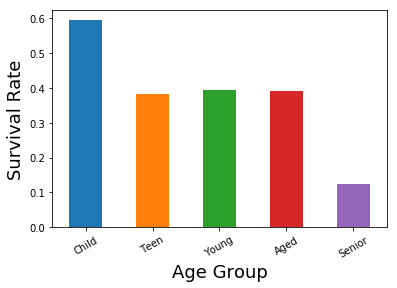

In [47]:
Age_group = pd.cut(train_df['Age'].values, [0,10,20,45,65,100], labels=['Child','Teen','Young','Aged', 'Senior'])

train_df['Survived'].groupby(Age_group).mean().plot.bar(rot=30)

plt.xlabel('Age Group', fontsize=18)
plt.ylabel('Survival Rate', fontsize=18);

### <a id='31'> Filling IN Missing Values with Group-Specific Statistic
When different groups have considerable different means, we need to apply this technique to achieve more accurate predictions.    
<a href='#0'> Back to TOC <br>

#### Task: are bills on weekends larger than weekdays in this restaurant?

##### Generate some NAs in total_bill for each weekday

In [56]:
na_idx = tips['day'].drop_duplicates().index  # cool trick !
tips.loc[na_idx, 'total_bill'] = np.nan
tips.iloc[na_idx][['total_bill','day']]

,total_bill,day
0,NaN,Sun
19,NaN,Sat
77,NaN,Thur
90,NaN,Fri


##### First question: is the average bill of each day different from the overall average bill?

In [131]:
pd.set_option('precision',2)

tips = pd.read_csv('examples/tips.csv')
tips.head(3)

print("Mean total bill: {:.1f}".format(tips['total_bill'].mean()))
print("Mean total bill on a different day is quite different from above:")
tips['total_bill'].groupby(tips['day']).mean()

,total_bill,tip,smoker,day,time,size
0,16.99,1.01,No,Sun,Dinner,2
1,10.34,1.66,No,Sun,Dinner,3
2,21.01,3.50,No,Sun,Dinner,3


Mean total bill: 19.8
Mean total bill on a different day is quite different from above:


day
Fri     17.15
Sat     20.44
Sun     21.41
Thur    17.68
Name: total_bill, dtype: float64

#### Filling in NAs using day-specific mean value

In [133]:
fillna_grp_mean = lambda s: s.fillna(s.mean()) # cool trick !
bill_fillna_grp_mean=tips.groupby('day')['total_bill'].apply(fillna_grp_mean)

# Let's compare it to filling in NA with a more generic overall mean
bill_fillna_mean = tips['total_bill'].fillna(tips['total_bill'].mean())

# Display the difference 
pd.concat([bill_fillna_grp_mean.rename('bill_fillna_group_mean'), 
           bill_fillna_mean.rename('bill_fillna_mean'), 
           tips['day'].rename('day')
          ], axis=1).iloc[na_idx]

,bill_fillna_group_mean,bill_fillna_mean,day
0,16.99,16.99,Sun
19,20.65,20.65,Sat
77,27.20,27.20,Thur
90,28.97,28.97,Fri


### <a id='33'> Example: Group Weighted Average and Correlation
- <a href='#0'> Back to TOC

In [82]:
df = pd.DataFrame({'Category': ['a', 'a', 'a', 'a',
                                'b', 'b', 'b', 'b'],
                   'Data': np.random.randn(8),
                   'Weights': np.random.rand(8)})
df.head(3)

,Category,Data,Weights
0,a,0.714604,0.656367
1,a,0.277678,0.938118
2,a,1.125553,0.824632


In [83]:
grb = df.groupby('Category')
get_w_avg = lambda g: np.average(g['Data'], weights=g['Weights'])
grb.apply(get_w_avg) 
grb.agg(get_w_avg) # Beware of the improper behavior of agg() here. It simply repeats the 
                   # function based on the number of columns in the groupby obj.  

Category
a    0.733947
b    0.415951
dtype: float64

,Data,Weights
Category,,
a,0.733947,0.733947
b,0.415951,0.415951


#### Yearly correlation b/t Stock Prices

In [84]:
!head -n4 examples/stock_px_2.csv

,AAPL,MSFT,XOM,SPX
2003-01-02 00:00:00,7.4,21.11,29.22,909.03
2003-01-03 00:00:00,7.45,21.14,29.24,908.59
2003-01-06 00:00:00,7.45,21.52,29.96,929.01


In [91]:
price_df = pd.read_csv('examples/stock_px_2.csv', 
                       index_col=0,
                       parse_dates=True,  # parse the index as a datetime obj
                      )
price_df.head(3)

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01


##### Overall correlation of SPX with other Stocks

In [98]:
price_df.drop('SPX', axis=1).corrwith(close_px['SPX'])

AAPL    0.244478
MSFT    0.746871
XOM     0.528731
dtype: float64

##### Yearly correlations

,AAPL,MSFT,XOM
2003,0.882692,0.675932,0.860104
2004,0.638080,0.593300,0.432642
2005,0.743263,0.746188,0.404042
2006,0.838252,0.824727,0.849528
2007,0.483093,0.292706,0.729426
2008,0.829417,0.919476,0.774885
2009,0.952895,0.950194,0.278447
2010,0.617886,0.469280,0.894656
2011,-0.552395,0.111688,0.912603


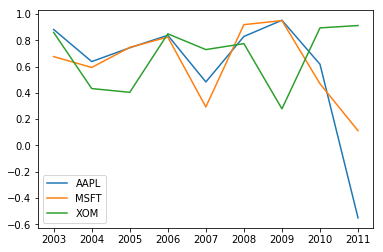

In [101]:
gby  =  price_df.groupby(lambda idx: idx.year) 
corr_func = lambda x: x.drop('SPX', axis=1).corrwith(x['SPX'])

yearly_corr = gby.apply(corr_func)
display(yearly_corr)
yearly_corr.plot(); 

## <a id='4'> Cross-Tabulations and Pivot Tables
For two categorical variables.
    
<a href='#0'> Back to TOC

In [56]:
# Load tips data
tips = pd.read_csv('examples/tips.csv')
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.head(3)

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.05945
1,10.34,1.66,No,Sun,Dinner,3,0.16054
2,21.01,3.50,No,Sun,Dinner,3,0.16659


### Pivot tables

#### How do weekday and time of the day affect how much people tip?

In [30]:
pd.set_option('precision', 5)

# It's good to have counts by the side to ensure good statistics
tips.pivot_table('tip_pct', index='day', columns='time', aggfunc=['mean','count'])

# equivalent groupby operation
tips.groupby(['day','time'])['tip_pct'].agg(['mean','count']).unstack()

mean           count      
time   Dinner    Lunch Dinner Lunch
day                                
Fri   0.15892  0.18876   12.0   7.0
Sat   0.15315      NaN   87.0   NaN
Sun   0.16690      NaN   76.0   NaN
Thur  0.15974  0.16130    1.0  61.0

mean           count      
time   Dinner    Lunch Dinner Lunch
day                                
Fri   0.15892  0.18876   12.0   7.0
Sat   0.15315      NaN   87.0   NaN
Sun   0.16690      NaN   76.0   NaN
Thur  0.15974  0.16130    1.0  61.0

### Cross-Tabulations
aka contigency table

#### What is the busiest time of the week in the restaurant?

In [78]:
tab = pd.crosstab(tips.day, tips.time, margins=False)
tab

# Which weekday is the busiest
tab.idxmax(axis=0)

time,Dinner,Lunch
day,,
Fri,12,7
Sat,87,0
Sun,76,0
Thur,1,61


time
Dinner     Sat
Lunch     Thur
dtype: object

Display percentages instead of counts

In [91]:
pd.set_option('precision',3)
pd.crosstab(tips.day, tips.time, margins=False, normalize='all') # normalize: index, columns, all

time,Dinner,Lunch
day,,
Fri,0.049,0.029
Sat,0.357,0.000
Sun,0.311,0.000
Thur,0.004,0.250


#### What is the time slot when it has the most smokers in the restaurant?

In [85]:
tab = pd.crosstab(tips.day, [tips.smoker,tips.time], margins=False)
tab

smoker     No          Yes      
time   Dinner Lunch Dinner Lunch
day                             
Fri         3     1      9     6
Sat        45     0     42     0
Sun        57     0     19     0
Thur        1    44      0    17

In [87]:
tab['Yes'].idxmax(axis=0)

time
Dinner     Sat
Lunch     Thur
dtype: object

<a href='#0'> Back to TOC